<a href="https://colab.research.google.com/github/KunalSingh-Physics/NLP-projects/blob/main/toxicity_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/CommentToxicity-main/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values


In [ ]:
MAX_FEATURES = 200000

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)


In [ ]:
#data pipeline #divides into batches of 16
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

Epoch 1/20
6981/6981 [==============================] - 803s 113ms/step - loss: 0.0656 - val_loss: 0.0452
Epoch 2/20
1252/6981 [====>.........................] - ETA: 8:15 - loss: 0.0473

KeyboardInterrupt: ignored

In [ ]:

history = model.fit(train, epochs=5, validation_data=val)


Epoch 1/5
6981/6981 [==============================] - ETA: 0s - loss: 0.0251
Epoch 1: saving model to /content/drive/MyDrive/ml projects/cp.ckpt
6981/6981 [==============================] - 706s 101ms/step - loss: 0.0251 - val_loss: 0.0258
Epoch 2/5
6981/6981 [==============================] - ETA: 0s - loss: 0.0225
Epoch 2: saving model to /content/drive/MyDrive/ml projects/cp.ckpt
6981/6981 [==============================] - 673s 96ms/step - loss: 0.0225 - val_loss: 0.0183
Epoch 3/5
6981/6981 [==============================] - ETA: 0s - loss: 0.0200
Epoch 3: saving model to /content/drive/MyDrive/ml projects/cp.ckpt
6981/6981 [==============================] - 692s 99ms/step - loss: 0.0200 - val_loss: 0.0169
Epoch 4/5
6981/6981 [==============================] - ETA: 0s - loss: 0.0177
Epoch 4: saving model to /content/drive/MyDrive/ml projects/cp.ckpt
6981/6981 [==============================] - 683s 98ms/step - loss: 0.0177 - val_loss: 0.0157
Epoch 5/5
6981/6981 [==================

<Figure size 800x500 with 0 Axes>

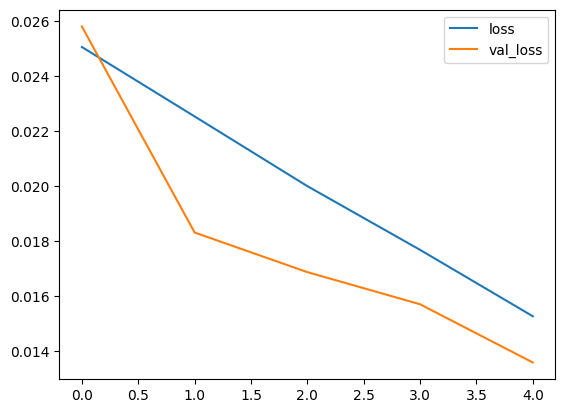

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


Precision: 0.9323200583457947, Recall:0.9445090293884277, Accuracy:0.5155466198921204


In [ ]:
model.save('/content/drive/MyDrive/ml projects/toxicity.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ml projects/toxicity.h5')


In [ ]:
input_str = vectorizer('hey i freaken hate you!')


In [ ]:
res = model.predict(np.expand_dims(input_str,0))


1/1 [==============================] - 0s 51ms/step


In [ ]:
res

array([[0.9412279 , 0.00162752, 0.0043924 , 0.03017796, 0.0360063 ,
        0.00852343]], dtype=float32)